<a href="https://colab.research.google.com/github/paskef/weather-analytics/blob/main/weather_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import

In [1]:
import requests
import json
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### Set the API Key

In [2]:
from google.colab import userdata

api_key = userdata.get('meteostat_api')


In [3]:
url = "https://meteostat.p.rapidapi.com/stations/monthly"

station_id = 83780

year = 2023
months = [(f"{year}-{month:02d}-01", f"{year}-{month:02d}-{calendar.monthrange(year, month)[1]:02d}") for month in range(1, 13)]


In [4]:
headers = {
    "X-RapidAPI-Key": api_key,
    "X-RapidAPI-Host": "meteostat.p.rapidapi.com"
}

data_list = []

#### Collecting and Structuring Monthly Weather Data

In [5]:
for start_date, end_date in months:
    querystring = {
        "station": station_id,
        "start": start_date,
        "end": end_date
    }

    response = requests.get(url, headers=headers, params=querystring)

    if response.status_code == 200:
        data = response.json().get('data', [])
        if not data:
            print(f"Data for {start_date} {end_date} not found")
        else:
            for entry in data:
                entry['start_date'] = start_date
                entry['end_date'] = end_date
                data_list.append(entry)
    elif response.status_code == 429:
        print(f"Rate limit exceeded. Sleeping for 5 seconds...")
        time.sleep(5)
    else:
         print(f"Error getting data for {start_date} to {end_date}: {response.status_code}")

Error getting data for 2023-01-01 to 2023-01-31: 522


#### Constructing the DataFrame for Weather Data Analysis

In [6]:
df = pd.DataFrame(data_list)
print(df.head())

         date  tavg  tmin  tmax   prcp  wspd    pres  tsun  start_date  \
0  2023-02-01  22.9  19.9  27.6  319.9  13.7  1016.9  None  2023-02-01   
1  2023-03-01  22.9  19.6  28.2  180.9  11.7  1018.3  None  2023-03-01   
2  2023-04-01  19.7  17.0  24.2   60.5  12.7  1018.5  None  2023-04-01   
3  2023-05-01  18.5  15.3  23.4   11.1  10.5  1021.4  None  2023-05-01   
4  2023-06-01  17.6  13.9  22.4   29.5  10.0  1022.9  None  2023-06-01   

     end_date  
0  2023-02-28  
1  2023-03-31  
2  2023-04-30  
3  2023-05-31  
4  2023-06-30  


#### Preparing DataFrame

In [7]:
df.drop(columns=['start_date', 'end_date'], inplace=True)
df.drop(columns=['wspd', 'pres', 'tsun'], inplace=True)
df.rename(columns={'prcp': 'precipitation'}, inplace=True)
df['month'] = df['date'].str[5:7]

In [8]:
monthly_data = df.groupby('month', as_index=False)[['tavg', 'precipitation']].first()

#### Plotting Monthly Temperature Averages

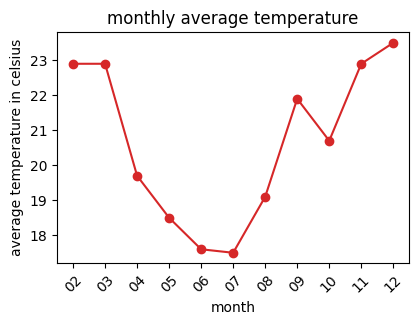

In [9]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(monthly_data['month'].astype(str), monthly_data['tavg'], marker='o', color='tab:red')
plt.title('monthly average temperature')
plt.xlabel('month')
plt.ylabel('average temperature in celsius')
plt.xticks(rotation=45)

plt.savefig('monthly_avg_temperature.png')


#### Plotting Monthly Precipitation

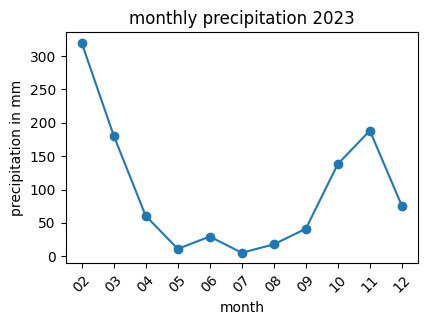

In [10]:


plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(monthly_data['month'].astype(str), monthly_data['precipitation'], marker='o', color='tab:blue')
plt.title('monthly precipitation 2023')
plt.xlabel('month')
plt.ylabel('precipitation in mm')
plt.xticks(rotation=45)

plt.savefig('monthly_precipitation.png')

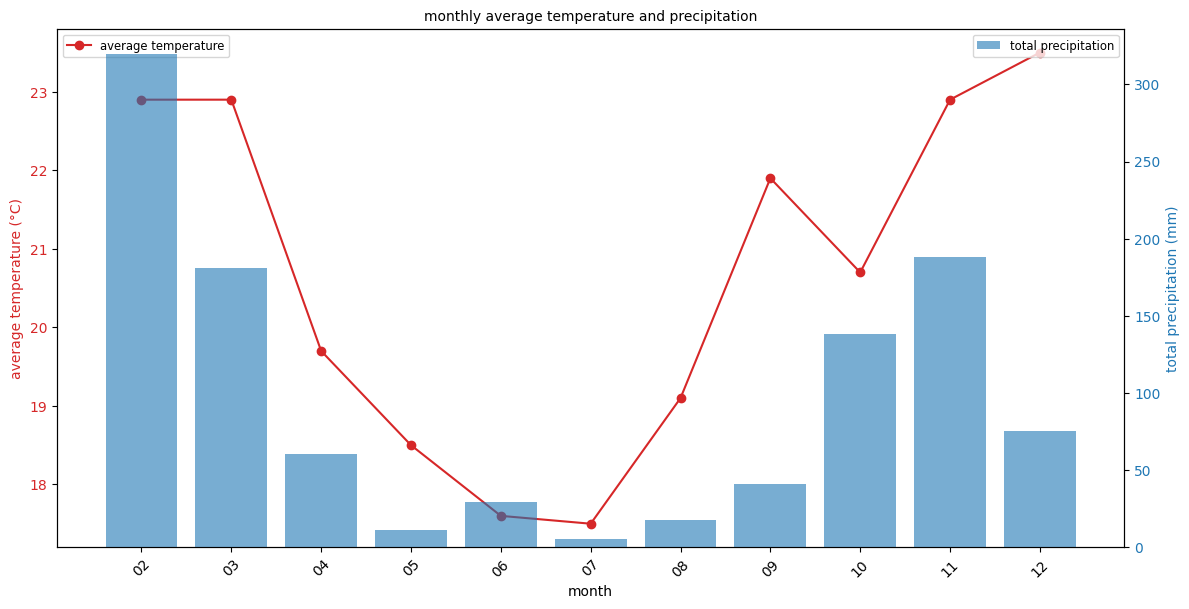

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# y-axis for avg temperature
ax1.set_xlabel('month')
ax1.set_ylabel('average temperature (°C)', color='tab:red')
ax1.plot(monthly_data['month'].astype(str), monthly_data['tavg'], marker='o', color='tab:red', label='average temperature')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax1.set_xticks(monthly_data['month'].astype(str))
ax1.set_xticklabels(monthly_data['month'].astype(str), rotation=45)
ax1.legend(loc='upper left', fontsize ='small')


# y-axis for precipitation
ax2 = ax1.twinx()
ax2.set_ylabel('total precipitation (mm)', color='tab:blue')
ax2.bar(monthly_data['month'].astype(str), monthly_data['precipitation'], alpha=0.6, color='tab:blue', label='total precipitation')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right', fontsize = 'small')

fig.tight_layout()
plt.title('monthly average temperature and precipitation', size ='10')
plt.savefig('monthly_avg_temperature_precipitation.png')
plt.show()